In [ ]:
#################################
#                               #
#         Deep Learning         #
#       Transfer Learning       #
#      Détection d'images       #
#                               #
#################################

In [9]:
# pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------------------------- ----------- 5.5/7.8 MB 30.5 MB/s eta 0:00:01
   ---------------------------------------- 7.8/7.8 MB 25.5 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 24.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 2.6/2.6 MB 24.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

In [ ]:
# Récupérer le modèle :
# https://pjreddie.com/media/files/yolov3.weights

# Récupérer le fichier de configuration :
# https://opencv-tutorial.readthedocs.io/en/latest/_downloads/10e685aad953495a95c17bfecd1649e5/yolov3.cfg

# Le modèle a été contruit à partir du jeu de données COCO (https://cocodataset.org/)

In [11]:
# Importe le modèle

net = cv2.dnn.readNetFromDarknet('yolo/darknet/yolov3.cfg', 'yolo/darknet/yolov3.weights')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\dnn\src\darknet\darknet_importer.cpp:210: error: (-212:Parsing error) Failed to open NetParameter file: yolo/darknet/yolov3.cfg in function 'cv::dnn::dnn4_v20240521::readNetFromDarknet'


In [4]:
# Importe la liste des objets détectables

objects_list = open('yolo/darknet/data/coco.names').read().strip().split('\n')
print(objects_list)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [5]:
pm = 0.5  # proba min pour les prédictions
td = 0.3  # seuil pour le "non maximum suppression"

In [6]:
# Noms des couches du CNN

layers_names = net.getLayerNames()
print(layers_names)

('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36', 'shortcut_36', 'conv_37', 'bn_37', 'leaky_

In [7]:
# Extraction des 3 couches utiles pour YOLO

layers_yolo = [layers_names[i-1] for i in net.getUnconnectedOutLayers()]
print(layers_yolo)

['yolo_82', 'yolo_94', 'yolo_106']


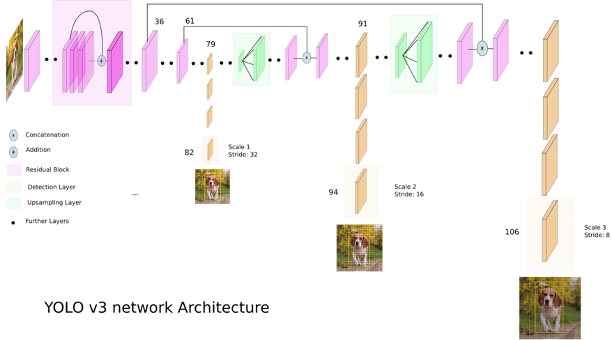

In [8]:
# Importation d'une image

image_input = cv2.imread('yolo/darknet/data/person.jpg')
image_input_shape = image_input.shape
h_dim = image_input.shape[0]
w_dim = image_input.shape[1]
print(image_input_shape)

(424, 640, 3)


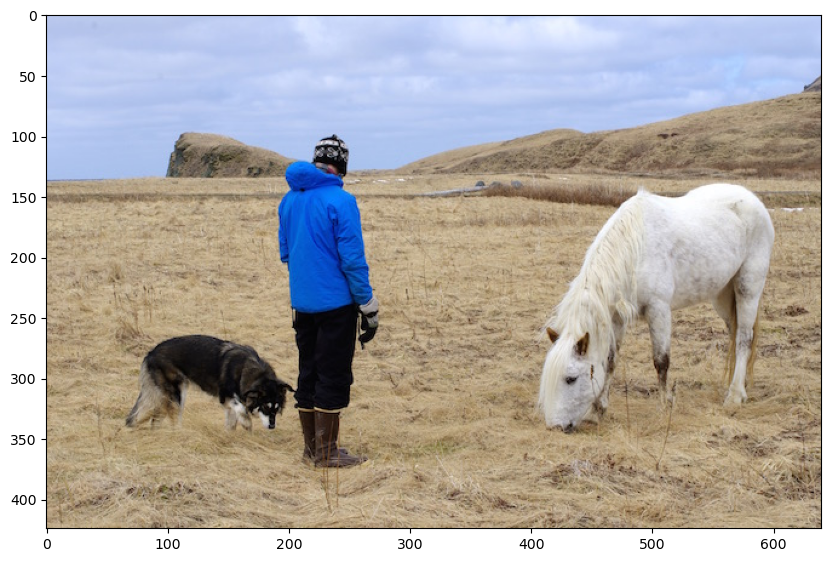

In [9]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
# Construit un 'blob' (input du modèle) à partir de l'image

blob = cv2.dnn.blobFromImage(image_input, 1 / 255.0, (416, 416), swapRB=True, crop=False)
print(blob.shape)

(1, 3, 416, 416)


In [11]:
# Pour visualiser le blob

blob_img = blob[0, :, :, :].transpose(1, 2, 0)
print(blob_img.shape)  # (416, 416, 3)

(416, 416, 3)


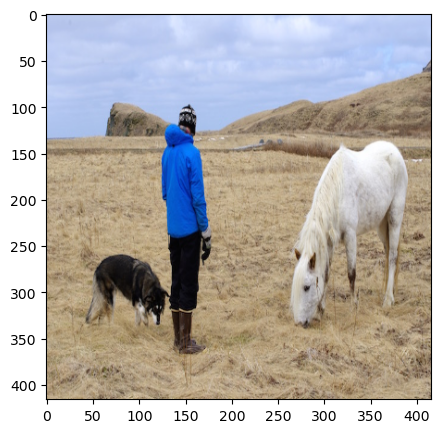

In [12]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(blob_img)
plt.show()

In [13]:
# calcul la sortie du modèle à partir du blob

net.setInput(blob)
start = time.time()
output = net.forward(layers_yolo)
end = time.time()
print('Temps {:.5f} secondes'.format(end - start))

Temps 0.37695 secondes


In [14]:
print(type(output))
print([len(a) for a in output])

<class 'tuple'>
[507, 2028, 8112]


In [29]:
print(output[0].shape)
print(output[1].shape)
print(output[2].shape)

(507, 85)
(2028, 85)
(8112, 85)


In [39]:
print(output[0][0])

[5.1336724e-02 3.3074066e-02 2.7621037e-01 1.8585855e-01 7.9386115e-09
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.000

In [40]:
print(output[0][265])  # horse

[0.7856898  0.52897084 0.33405942 0.50879186 0.9123031  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.9069968  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


In [17]:
# Génère aléatoirement une couleur par type d'objet détecté

np.random.seed(42)
colours = np.random.randint(0, 255, size=(len(objects_list), 3), dtype='uint8')
print(colours.shape)
print(colours[0]) 

(80, 3)
[102 220 225]


In [18]:
# Initialise les listes des sorties

bounding_boxes = []
confidences = []
classes = []

In [41]:
# Extrait les sorties du modèle
i = 0
for result in output:
    for detection in result:
        # Extrait la classe de l'objet et le score de confiance associé
        scores = detection[5:]
        clas = np.argmax(scores)
        confid = scores[clas]
        if confid > pm:
            print(i)
            # adapte les "bounding box" à la taille initiale de l'image
            box = detection[0:4] * np.array([w_dim, h_dim, w_dim, h_dim])
            x_center, y_center, box_width, box_height = box.astype('int')
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))
            # ajout aux listes des sorties
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confid))
            classes.append(clas)
        i += 1

265
286
301
304
357
360
1550
1628
1706
1928


In [20]:
bounding_boxes

[[395, 116, 213, 215],
 [181, 94, 104, 279],
 [386, 137, 205, 210],
 [394, 137, 213, 206],
 [59, 262, 146, 88],
 [70, 261, 164, 90],
 [189, 92, 87, 266],
 [190, 94, 86, 284],
 [188, 108, 90, 275],
 [76, 262, 118, 86]]

In [21]:
confidences

[0.9069967865943909,
 0.9393004775047302,
 0.9813554286956787,
 0.9977790713310242,
 0.9943850040435791,
 0.7588033080101013,
 0.996246337890625,
 0.9999476671218872,
 0.9900867938995361,
 0.8048283457756042]

In [22]:
classes

[17, 0, 17, 17, 16, 16, 0, 0, 0, 16]

In [23]:
# Non maximum suppression

results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, pm, td)

for i in range(len(classes)):
    print(objects_list[int(classes[i])])

with open('found_objects.txt', 'w') as f:
    for i in range(len(classes)):
        f.write(objects_list[int(classes[i])])

horse
person
horse
horse
dog
dog
person
person
person
dog


In [26]:
# Dessine les bounging box sur l'image originelle

if len(results) > 0:
    for i in results.flatten():
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
        colour_box = [int(j) for j in colours[classes[i]]]
        cv2.rectangle(image_input, (x_min, y_min), (x_min + box_width, y_min + box_height), colour_box, 3)
        text_box = '{}: {:.4f}'.format(objects_list[int(classes[i])], confidences[i])
        cv2.putText(image_input, text_box, (x_min, y_min - 7), cv2.FONT_HERSHEY_SIMPLEX,0.5, colour_box, 2)

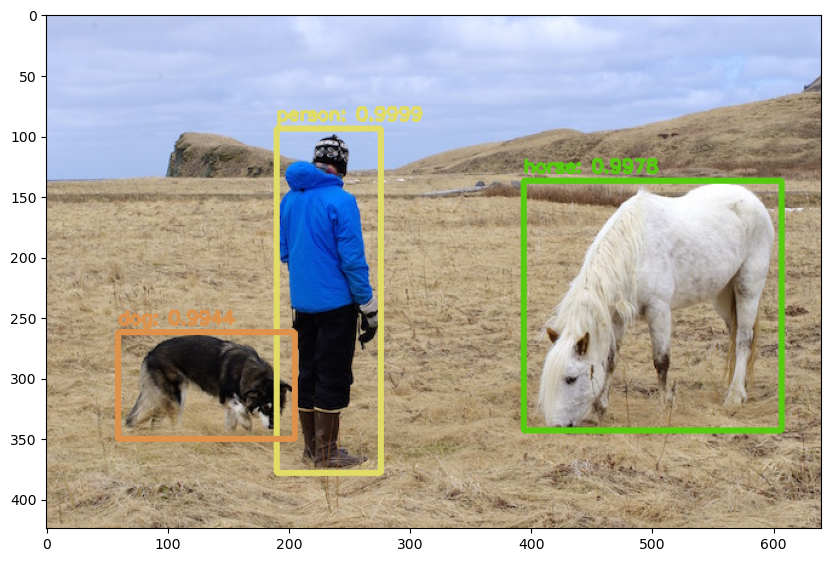

In [27]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()